# Reading, Processing , Modelling

Loading data...
Found 200000 valid images and 0 invalid images
Data loading completed
Building model...
Model built successfully
Starting training...
Epoch 1/50


I0000 00:00:1732356954.441976     113 service.cc:145] XLA service 0x7d2e48018140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732356954.442043     113 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732356954.442049     113 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732356963.985852     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - kl_loss: 38.2539 - loss: 521.2421 - reconstruction_loss: 482.9881
Epoch 1: reconstruction_loss improved from inf to 383.61984, saving model to vae_best_model.keras


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 228s 34ms/step - kl_loss: 38.2549 - loss: 521.2272 - reconstruction_loss: 482.9722 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: reconstruction_loss did not improve from 383.61984
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step - kl_loss: 44.4067 - loss: 428.0259 - reconstruction_loss: 383.6198 - learning_rate: 1.0000e-04
Epoch 3/50
   5/6250 ━━━━━━━━━━━━━━━━━━━━ 3:09 30ms/step - kl_loss: 56.7329 - loss: 382.6905 - reconstruction_loss: 325.9576

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - kl_loss: 55.2256 - loss: 371.6801 - reconstruction_loss: 316.4547
Epoch 3: reconstruction_loss improved from 383.61984 to 308.64783, saving model to vae_best_model.keras
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 215s 34ms/step - kl_loss: 55.2254 - loss: 371.6786 - reconstruction_loss: 316.4535 - learning_rate: 1.0000e-04
Epoch 4/50

Epoch 4: reconstruction_loss did not improve from 308.64783
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step - kl_loss: 53.9073 - loss: 362.5555 - reconstruction_loss: 308.6478 - learning_rate: 1.0000e-04
Epoch 5/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - kl_loss: 59.5587 - loss: 357.8773 - reconstruction_loss: 298.3184
Epoch 5: reconstruction_loss improved from 308.64783 to 294.22830, saving model to vae_best_model.keras
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 210s 34ms/step - kl_loss: 59.5584 - loss: 357.8763 - reconstruction_loss: 298.3177 - learning_rate: 1.0000e-04
Epoch 6/50

Epoch 6: reconstruction_loss did not improve from 

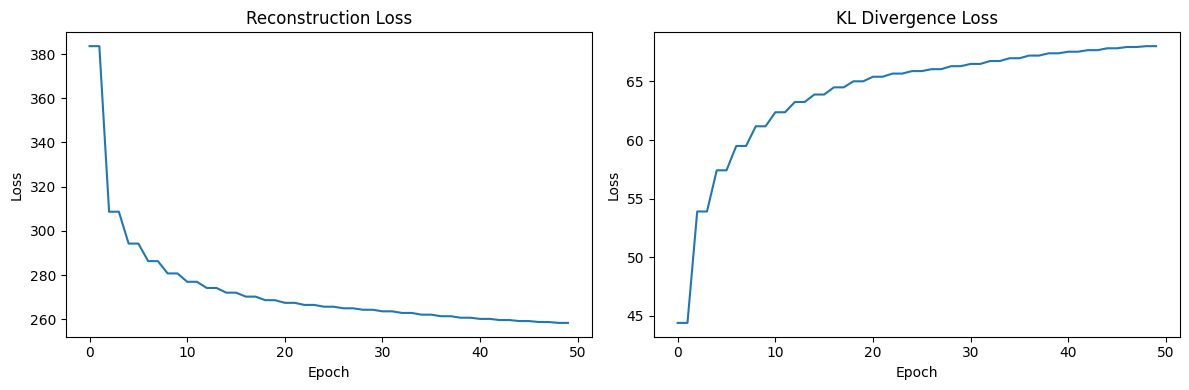

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import json
from collections import defaultdict
import numpy as np
from concurrent.futures import ThreadPoolExecutor

# Define constants
IMG_DIR = '/kaggle/input/yelp-photos/photos'
JSON_FILE = '/kaggle/input/yelp-photos/photos.json'
IMG_SIZE = (64, 64)
BATCH_SIZE = 32

def validate_image(image_path):
    """Validate if the image file exists and can be opened"""
    try:
        with tf.io.gfile.GFile(image_path, 'rb') as f:
            img_data = f.read()
        # Try decoding the image to verify it's valid
        tf.image.decode_image(img_data)
        return True
    except Exception as e:
        print(f"Error validating image {image_path}: {str(e)}")
        return False

def parse_json(json_file):
    class_image_map = defaultdict(list)
    try:
        with open(json_file, 'r') as f:
            for line in f:
                entry = json.loads(line.strip())
                label = entry.get('label')
                photo_id = entry.get('photo_id')
                if label is not None and photo_id is not None:
                    class_image_map[label].append(photo_id)
    except Exception as e:
        print(f"Error parsing JSON file: {str(e)}")
        raise
    return class_image_map

def load_full_dataset(class_image_map, img_dir):
    image_paths_with_labels = []
    valid_images = 0
    invalid_images = 0

    def process_image(photo_id, label):
        nonlocal valid_images, invalid_images
        img_path = os.path.join(img_dir, f"{photo_id}.jpg")
        if os.path.exists(img_path) and validate_image(img_path):
            image_paths_with_labels.append((img_path, label))
            valid_images += 1
        else:
            invalid_images += 1

    with ThreadPoolExecutor() as executor:
        futures = []
        for label, photo_ids in class_image_map.items():
            for photo_id in photo_ids:
                futures.append(executor.submit(process_image, photo_id, label))
        for future in futures:
            future.result()

    print(f"Found {valid_images} valid images and {invalid_images} invalid images")
    return image_paths_with_labels

def preprocess_image(image_path, label):
    """Preprocess a single image with error handling"""
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, IMG_SIZE)
        image = tf.cast(image, tf.float32) / 255.0
        return image
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return tf.zeros(IMG_SIZE + (3,))

def create_dataset(image_paths_with_labels, img_size, batch_size):
    if not image_paths_with_labels:
        raise ValueError("No valid images found in the dataset")

    image_paths, _ = zip(*image_paths_with_labels)
    dataset = tf.data.Dataset.from_tensor_slices(list(image_paths))
    dataset = dataset.map(lambda x: preprocess_image(x, None),
                         num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 0)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(latent_dim):
    encoder_inputs = tf.keras.layers.Input(shape=(64, 64, 3))

    # Convolutional layers
    x = tf.keras.layers.Conv2D(32, 4, strides=2, padding='same')(encoder_inputs)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    # Flatten and Dense layers
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    # Output layers
    z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder

def build_decoder(latent_dim):
    decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))

    # Dense layers
    x = tf.keras.layers.Dense(512)(decoder_inputs)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dense(4 * 4 * 256)(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Reshape((4, 4, 256))(x)

    # Transposed convolution layers
    x = tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv2DTranspose(32, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv2DTranspose(16, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    # Output layer
    decoder_outputs = tf.keras.layers.Conv2D(3, 3, padding='same', activation='sigmoid')(x)

    decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')
    return decoder

class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = build_encoder(latent_dim)
        self.decoder = build_decoder(latent_dim)

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Get encoder outputs
            z_mean, z_log_var, z = self.encoder(data)
            # Get reconstruction
            reconstruction = self.decoder(z)

            # Compute reconstruction loss - MSE instead of binary crossentropy
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(data - reconstruction),
                    axis=[1, 2, 3]
                )
            )

            # Compute KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )

            # Total loss with beta-VAE weighting
            beta = 1.0  # Adjust this value to control disentanglement
            total_loss = reconstruction_loss + beta * kl_loss

        # Compute and apply gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Main execution
try:
    # Load and prepare data
    print("Loading data...")
    class_image_map = parse_json(JSON_FILE)
    image_paths_with_labels = load_full_dataset(class_image_map, IMG_DIR)
    dataset = create_dataset(image_paths_with_labels, IMG_SIZE, BATCH_SIZE)
    print("Data loading completed")

    # Create and compile VAE
    print("Building model...")
    LATENT_DIM = 128
    vae = VAE(LATENT_DIM)
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
    print("Model built successfully")

    # Train the model
    print("Starting training...")
    steps_per_epoch = len(image_paths_with_labels) // BATCH_SIZE

    history = vae.fit(
    dataset,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='reconstruction_loss',
            mode='min',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='reconstruction_loss',
            mode='min',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'vae_best_model.keras',  # Updated to '.keras'
            monitor='reconstruction_loss',
            mode='min',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir='./logs',
            write_graph=True,
            write_images=True,
            update_freq='epoch'
        )
    ]
)

    print("Training completed successfully")

    # Save the final model
    vae.save('vae_final_model.h5')

    # Plot training history
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 4))

    # Plot reconstruction loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['reconstruction_loss'])
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot KL loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['kl_loss'])
    plt.title('KL Divergence Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {str(e)}")
    raise


# Generate Images 

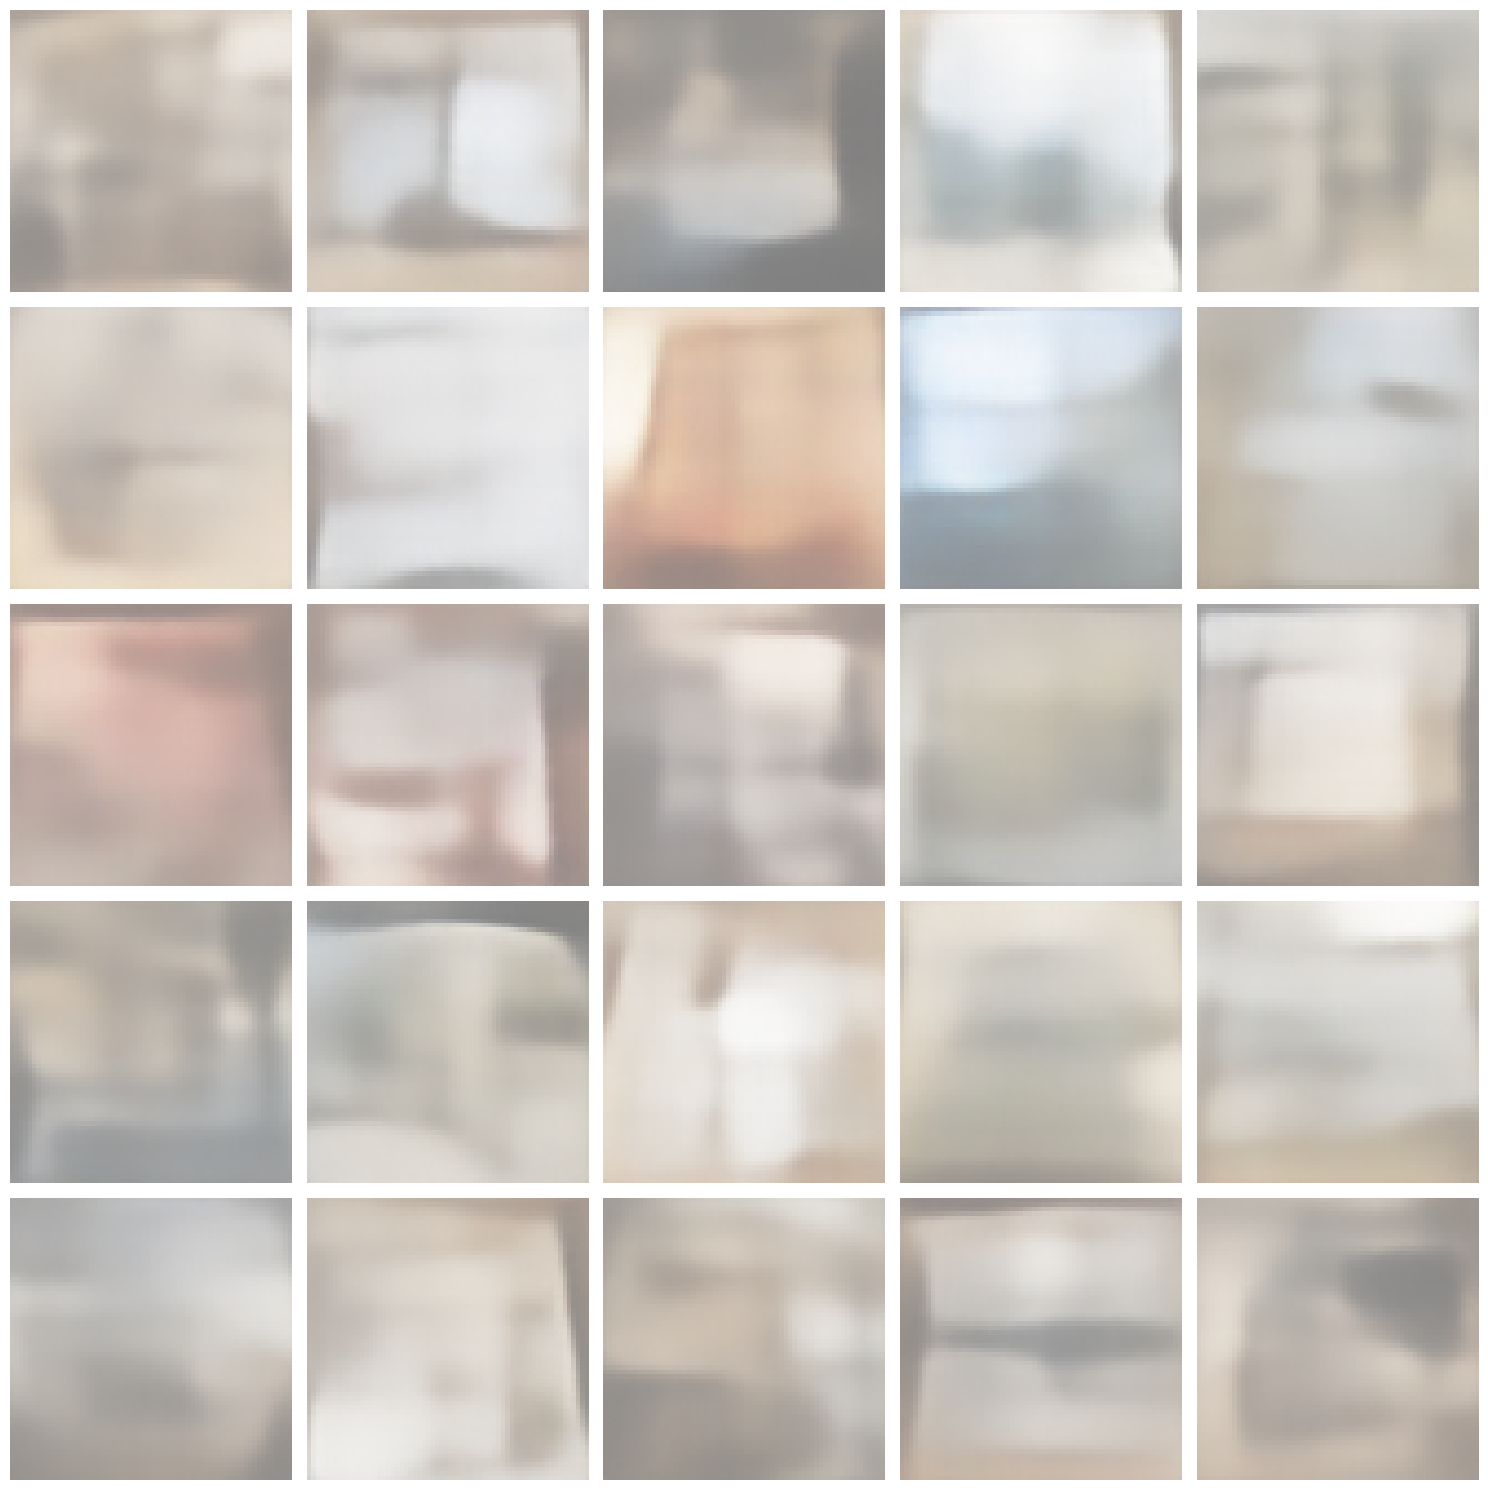

In [7]:
import matplotlib.pyplot as plt

# Generate new images
def generate_images(vae, num_images=25):
    random_latent_vectors = tf.random.normal(shape=(num_images, LATENT_DIM))
    generated_images = vae.decoder(random_latent_vectors)
    generated_images = (generated_images + 1) / 2.0  # Rescale to [0, 1]
    return generated_images

# Generate 25 images
generated_images = generate_images(vae, num_images=25)

# Plot the images
plt.figure(figsize=(15, 15))
for i in range(len(generated_images)):
    plt.subplot(5, 5, i + 1)  # 5x5 grid for 25 images
    plt.imshow(generated_images[i])
    plt.axis("off")
plt.tight_layout()
plt.show()


# Calcualte Errors : FID Score, Inception Score

In [8]:
import tensorflow as tf
import numpy as np
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model

# Load the pre-trained InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def preprocess_images(images):
    images = tf.image.resize(images, (299, 299))
    images = preprocess_input(images)
    return images

def get_inception_features(images):
    images = preprocess_images(images)
    features = inception_model.predict(images)
    return features

def calculate_inception_score(generated_images, num_splits=10):
    features = get_inception_features(generated_images)
    scores = []
    n_part = int(generated_images.shape[0] / num_splits)

    for i in range(num_splits):
        part = features[i * n_part:(i + 1) * n_part]
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean(np.sum(part * (np.log(part + 1e-10) - np.log(py + 1e-10)), axis=1))))

    return np.mean(scores), np.std(scores)

def calculate_fid(real_images, generated_images):
    real_features = get_inception_features(real_images)
    generated_features = get_inception_features(generated_images)

    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Generate new images
generated_images = generate_images(vae, num_images=100)  # Generate 100 images for evaluation

# Load real images for FID calculation
real_images = []
for image_path, _ in image_paths_with_labels[:100]:  # Load 100 real images
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (64, 64))
    image = tf.cast(image, tf.float32) / 255.0
    real_images.append(image)
real_images = np.array(real_images)

# Calculate Inception Score
inception_score_mean, inception_score_std = calculate_inception_score(generated_images)
print(f"Inception Score: {inception_score_mean} ± {inception_score_std}")

# Calculate FID Score
fid_score = calculate_fid(real_images, generated_images)
print(f"FID Score: {fid_score}")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
Inception Score: 1.0797879695892334 ± 0.017923666164278984
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
FID Score: 6.556489333575231
